In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

In [41]:
def moments(row):
    idade = row['idade']
    renda_mensal = row['renda_mensal']
    investimento_total = row['investimento_total']
    
    if 0 <= idade < 16:
        return 'Momento 1'
    elif 16 <= idade < 26:
        return 'Momento 2'
    elif 26 <= idade < 60:
        if renda_mensal >= 5e3:
            if investimento_total < 2e5:
                return 'Momento 6'
            else:
                return 'Momento 7'
        elif (idade < 36) and (renda_mensal < 5e3):
            return 'Momento 3'
        elif (idade < 45) and (renda_mensal < 5e3):
            return 'Momento 4'
        elif renda_mensal < 5e3:
            return 'Momento 5'
    elif idade >= 60:
        if renda_mensal < 5e3:
            return 'Momento 8'
        else:
            return 'Momento 9'

In [42]:
df = pd.read_csv(
    'ldw-base_relacionamento_atual.csv',
    delimiter=';',
    dtype={'cod_carteira': str}
    )\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str,
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0}),
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        investimento_total=lambda x: x.sld_lci + x.sld_lca + x.sld_fundos + x.sld_dep_a_prazo,
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        #alavancagem=lambda x: x.sld_cred_scr_2m / x.renda_mensal,
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ],
    )\
    .query('(status_associado == "ATIVO") and ~renda_mensal.isna()')\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[(df.idade < 15) & (df.renda_mensal > 1e2), 'renda_mensal'] = 0
df.loc[
    (df.idade >= 19) &
    (df.renda_mensal <= 100) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan
df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('median')

In [43]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal
df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1)
    )\
    .query('desc_cbo != "Diretor de produção e operações em empresa pesqueira"')\
    .reset_index(drop=True)

In [122]:
df_cluster = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'tempo_assoc', 'score_principalidade',
        'isa', 'sld_previdencia',
        'qt_investimento_media',
        #'alavancagem',
        'sld_inad_ca_0', 'sld_cred_scr_2m'
        ] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist() +
        df.columns[df.columns.str.startswith('mc_') & ~df.columns.isin([
            'mc_assoc', 'mc_assoc_6_meses', 'mc_total'
        ])].tolist() +
        df.filter(like='vlr_prej').columns.tolist() #+
        #df.filter(like='vlr_prov').columns.tolist()
    ]
df_cluster_columns = df_cluster.columns.tolist()
df_cluster = StandardScaler().fit_transform(df_cluster)

In [124]:
class Inertia: 
    def __init__(self, data, cluster_columns=None, set_groups=20):
        self.set_groups = set_groups + 1
        self.data = data
        self.data_cluster = data.loc[:, cluster_columns]
        self.cluster_columns = cluster_columns

    def find_groups(self, n_clusters):
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            random_state=42
            ).fit(self.data_cluster)\
            .labels_
    
    def calc_inertia(self):
        return [
            KMeans(
                n_clusters=i,
                init='k-means++',
                random_state=42
            ).fit(self.data_cluster)\
            .labels_
            for i in range(1, self.set_groups)
        ]

    def plot_inertia(self):
        plt.figure(figsize=(10, 8))
        plt.plot(
            range(1, self.set_groups),
            self.calc_inertia(),
            marker='o', 
            linestyle='--'
        )

In [125]:
for seed in range(43):
    kmeans = KMeans(
        n_clusters=10,
        tol=1e-16,
        random_state=seed
        ).fit(df_cluster)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}, {seed}")

Number of elements assigned to each cluster: [104963      1   1335      4  55075     13      1    192      1      1], 0
Number of elements assigned to each cluster: [  1108 104440  54578      1      1      5     36   1261    155      1], 1
Number of elements assigned to each cluster: [110784      1      1     12      3     15  50728      3      5     34], 2
Number of elements assigned to each cluster: [    68 104414     11  55316      1      1   1755      5     14      1], 3
Number of elements assigned to each cluster: [21755 88791    14     3 48818  1971   231     1     1     1], 4
Number of elements assigned to each cluster: [21313 52649     1 87449     1    27     1     6   132     7], 5
Number of elements assigned to each cluster: [48995 90933     1 20309     1     1     1     1     1  1343], 6
Number of elements assigned to each cluster: [101647    105  56230      7     12      1      1      7   1385   2191], 7
Number of elements assigned to each cluster: [110490      1      7    

In [126]:
kmeans = KMeans(
    n_clusters=10,
    tol=1e-16,
    random_state=31
    ).fit(df_cluster)

In [127]:
df = df.assign(
    Grupos=kmeans.labels_
    )\
    .sort_values('Grupos')\
    .astype({'Grupos': str})

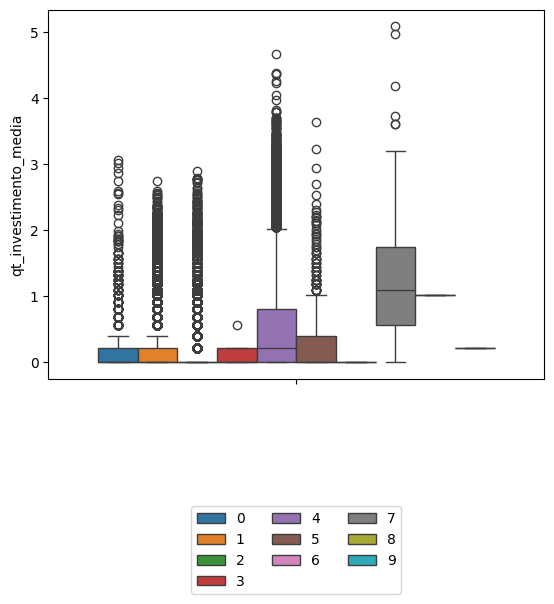

In [198]:
sns.boxplot(
    data=df\
        .assign(qt_investimento_media=lambda x: np.log1p(x.qt_investimento_media)),
    y='qt_investimento_media',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

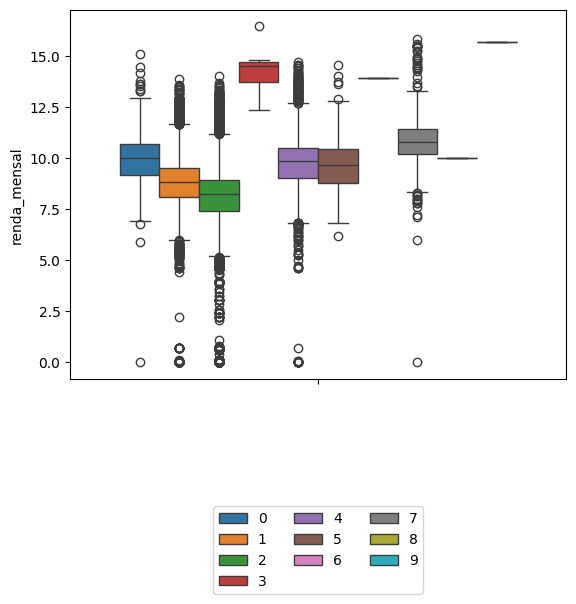

In [ ]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='renda_mensal',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

/mnt/c/Users/jesus_gabriel/Documents/seg/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/c/Users/jesus_gabriel/Documents/seg/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


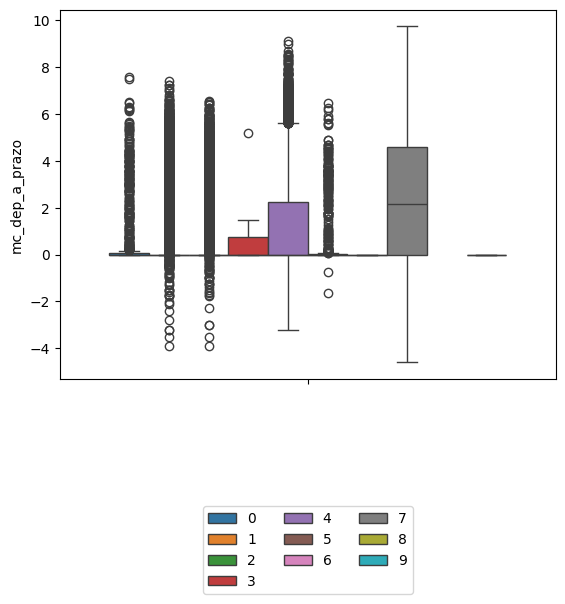

In [228]:
sns.boxplot(
    data=df\
        .assign(mc_dep_a_prazo=lambda x: np.log1p(x.mc_dep_a_prazo)),
    y='mc_dep_a_prazo',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

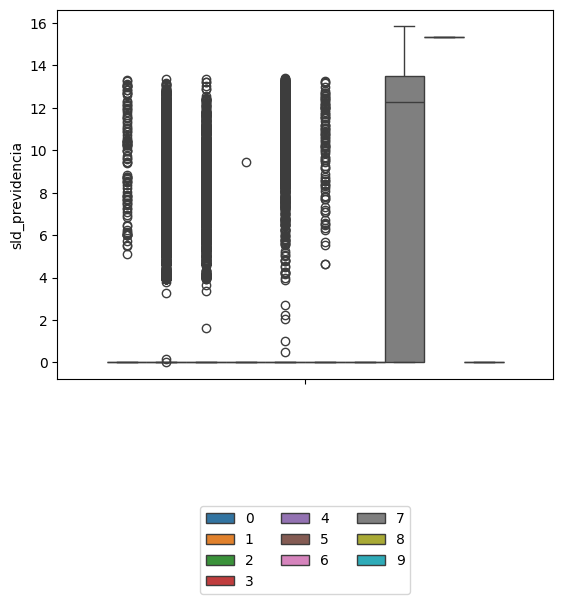

In [213]:
sns.boxplot(
    data=df\
        .assign(sld_previdencia=lambda x: np.log1p(x.sld_previdencia)),
    y='sld_previdencia',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

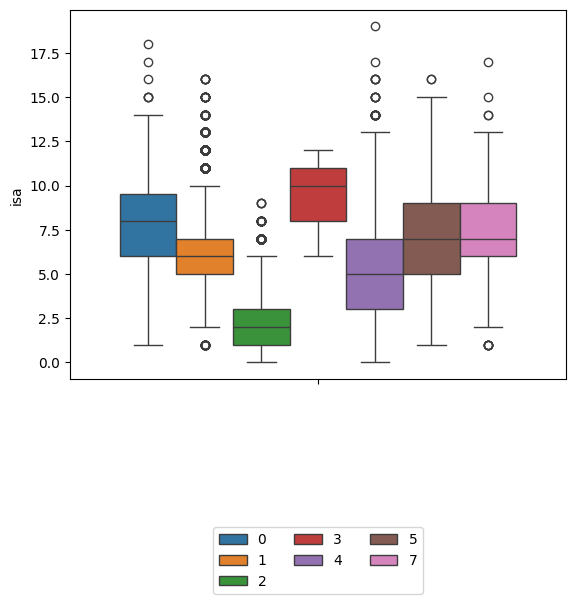

In [209]:
sns.boxplot(
    data=df.query('Grupos not in ["9", "8", "6"]'),
    y='isa',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

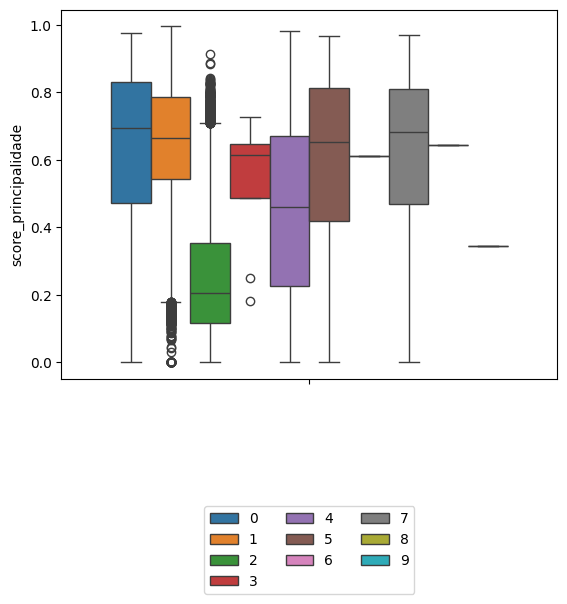

In [158]:
sns.boxplot(
    data=df,
    y='score_principalidade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

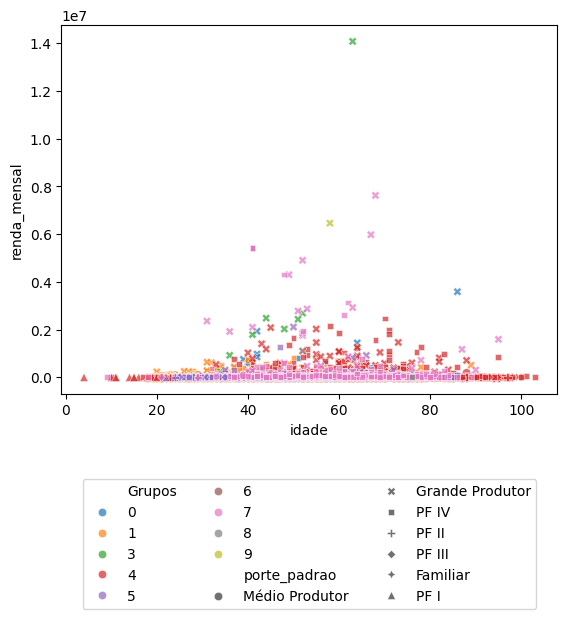

In [142]:
sns.scatterplot(
    data=df\
        .query('Grupos not in ["2"]')\
        .assign(
            vlr_prej_cred_comercial=lambda x: np.log1p(x.vlr_prej_cred_comercial)
        ),
    x='idade',
    y='renda_mensal',
    style='porte_padrao',
    hue='Grupos',
    alpha=.7
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

In [ ]:
stack_df = df.loc[:,
                df.columns[df.columns.str.startswith('prod_')].tolist()
                + ['Grupos']
            ]\
            .set_index('Grupos')\
            .stack()\
            .reset_index(name='contem')\
            .astype({'contem': int})\
            .rename(columns={'level_1': 'produto'})\
            .groupby(['Grupos', 'produto'])\
            .contem\
            .sum()\
            .reset_index(name='total_produto_grupo')

In [133]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(
        n_clusters=i,
        init='k-means++',
        random_state=42
    )
    kmeans_pca.fit(df_cluster)
    wcss.append(kmeans_pca.inertia_)

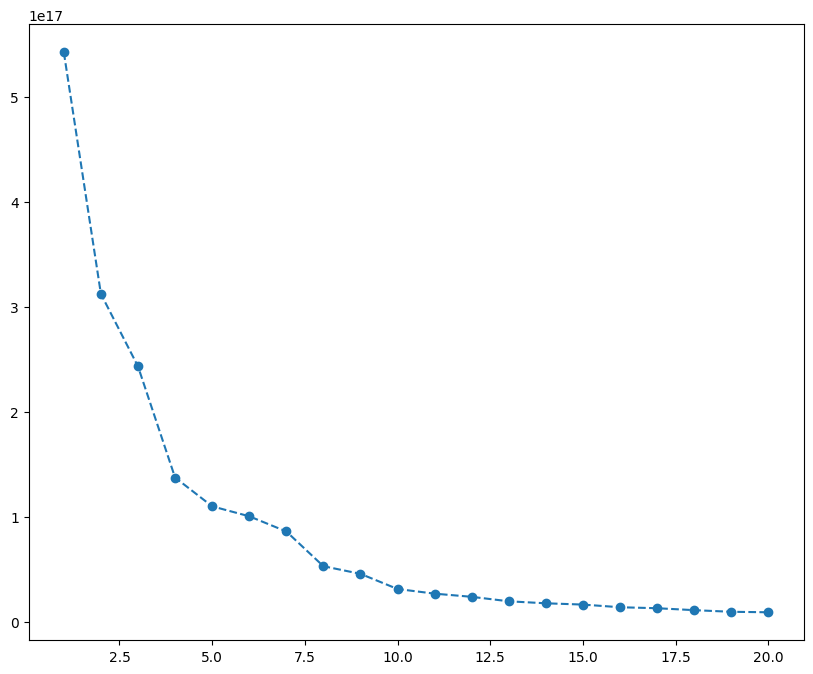

In [134]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')

In [214]:
df.to_csv('relacionamento_clusters.csv', index=False)